In [2]:
!pip install pandas

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import os
THREADS = 1
os.environ["OMP_NUM_THREADS"] = str(THREADS)
os.environ["OPENBLAS_NUM_THREADS"] = str(THREADS) 
os.environ["MKL_NUM_THREADS"] = str(THREADS) 
os.environ["VECLIB_MAXIMUM_THREADS"] = str(THREADS) 
os.environ["NUMEXPR_NUM_THREADS"] = str(THREADS)
import cupy as cp
import pystrel as ps
import pandas as pd
import scipy.special as sp
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

In [ ]:
def benchmark(*, L, method, device, sparsity):

    model = ps.Model({
        "sites": L,
        "terms": {
            "gamma": {(i, i+1): 1.0 for i in range(L-1)},
            "Jz": {(i, i+1): -1.0 for i in range(L-1)},
            "hz": {i: 1.0 for i in range(L)},
        }
    })

    def build_hamiltonian(t=0.0):
        return model.build_hamiltonian(dtype=np.complex128, device=device, sparsity=sparsity)

    def propagate(psi):
        ps.propagate(psi, build_hamiltonian, t0=0.0, dt=0.01, method=method)
        if device == "gpu":
            cp.cuda.Device().synchronize()

    h = build_hamiltonian()
    _, v = ps.spectrum.get_partial_spectrum(h, k=5)
    psi = v[0]
    
    result = %timeit -q -o -n 10 -r 1 _ = propagate(psi)
    return result

In [ ]:
def run(rrange, method="rk4", device="cpu", sparsity="dense"):
    sizes = []
    times = []
    for L in rrange:
        r = benchmark(L=L, method=method, device="cpu", sparsity=sparsity)
        times.append(r.average)
        sizes.append(int(sp.binom(L, L / 2)))
        print (L, r.average)

    clear_output()
    df = pd.DataFrame({"size": sizes, "time": times})
    df.to_csv(f"tmp_dynamics_benchmark_{method}_{sparsity}_{device}_{THREADS}.csv")
    return df

In [ ]:
run(range(6, 16), method="rk4", device="cpu", sparsity="dense")

In [ ]:
run(range(6, 16), method="cheb", device="cpu", sparsity="dense")

In [ ]:
run(range(6, 18), method="rk4", device="cpu", sparsity="sparse")

In [ ]:
run(range(6, 18), method="cheb", device="cpu", sparsity="sparse")

In [ ]:
if THREADS == 1:
    run(range(6, 16), method="rk4", device="gpu", sparsity="dense")

In [ ]:
if THREADS == 1:
    run(range(6, 16), method="cheb", device="gpu", sparsity="dense")   

In [ ]:
if THREADS == 1:
    run(range(6, 18), method="rk4", device="gpu", sparsity="sparse")

In [ ]:
if THREADS == 1:
    run(range(6, 18), method="cheb", device="gpu", sparsity="sparse")

In [3]:
df_cheb_dense = {}
df_cheb_sparse = {}
df_rk4_dense = {}
df_rk4_sparse = {}

for i in ["cpu_1", "cpu_2", "cpu_4", "cpu_8", "gpu_1"]:
    df_cheb_dense[i] = pd.read_csv(f"tmp_dynamics_benchmark_cheb_dense_{i}.csv")

for i in ["cpu_1", "cpu_2", "cpu_4", "cpu_8", "gpu_1"]:
    df_cheb_sparse[i] = pd.read_csv(f"tmp_dynamics_benchmark_cheb_sparse_{i}.csv")

for i in ["cpu_1", "cpu_2", "cpu_4", "cpu_8", "gpu_1"]:
    df_rk4_dense[i] = pd.read_csv(f"tmp_dynamics_benchmark_rk4_dense_{i}.csv")

for i in ["cpu_1", "cpu_2", "cpu_4", "cpu_8", "gpu_1"]:
    df_rk4_sparse[i] = pd.read_csv(f"tmp_dynamics_benchmark_rk4_sparse_{i}.csv")

In [4]:
def plot(df, label, style=None):
    if style is None:
        plt.plot(df["size"], df["time"], label=label)
    else:
        plt.plot(df["size"], df["time"], style, label=label)

def plot_all(df_dict, title):
    plt.title(title)
    plot(df_dict["cpu_1"], 'cpu_1')
    plot(df_dict["cpu_2"], 'cpu_2')
    plot(df_dict["cpu_4"], 'cpu_4')
    plot(df_dict["cpu_8"], 'cpu_8')
    plot(df_dict["gpu_1"], 'gpu_1')
    plt.xlabel('Hilbert space size')
    plt.ylabel('time (s)')
    plt.legend()
    plt.loglog()
    plt.show()

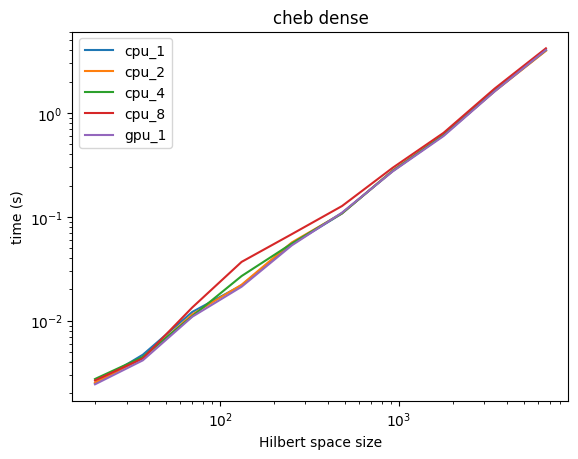

In [5]:
plot_all(df_cheb_dense, "cheb dense")

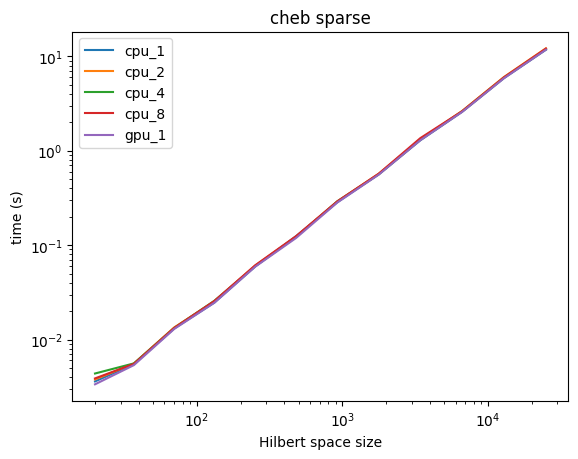

In [6]:
plot_all(df_cheb_sparse, "cheb sparse")

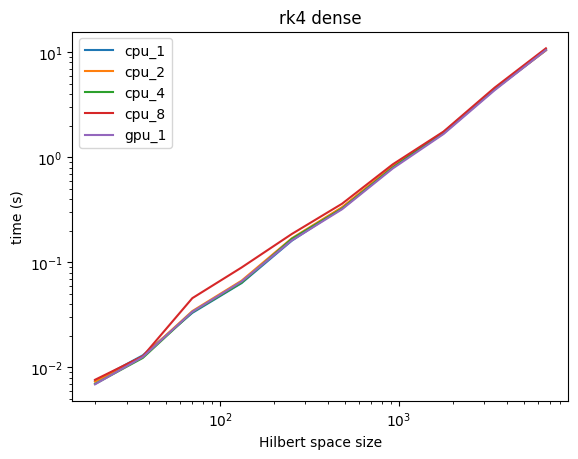

In [7]:
plot_all(df_rk4_dense, "rk4 dense")

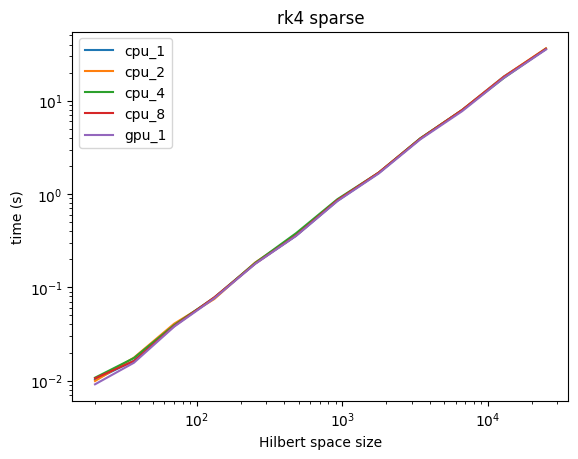

In [8]:
plot_all(df_rk4_sparse, "rk4 sparse")


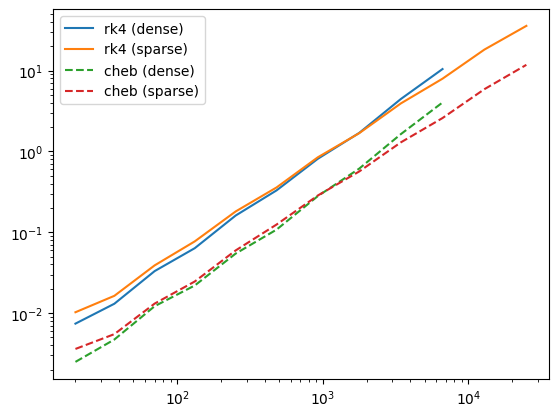

In [9]:
plot(df_rk4_dense["cpu_1"], 'rk4 (dense)')
plot(df_rk4_sparse["cpu_1"], 'rk4 (sparse)')
plot(df_cheb_dense["cpu_1"], 'cheb (dense)', '--')
plot(df_cheb_sparse["cpu_1"], 'cheb (sparse)', '--')
plt.legend()
plt.loglog()
plt.show()